In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

In [2]:
# Loading data sets
full_data_BatchA = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/data/full_data_BatchA.csv')
y = full_data_BatchA['Label'].to_numpy()
X_morgan = full_data_BatchA.drop(['Label'], axis = 1).to_numpy()

In [3]:
print(f'Initial class count in Batch A:\n {Counter(y)}')

Initial class count in Batch A:
 Counter({0: 5092, 1: 51})


In [4]:
# Split proportionally
X_train, X_test, y_train, y_test = train_test_split(X_morgan, y, test_size=0.2, stratify=y, random_state=6752)
print(f'Class count in TRAIN: {Counter(y_train)}')
print(f'Class count in TEST: {Counter(y_test)}')

Class count in TRAIN: Counter({0: 4073, 1: 41})
Class count in TEST: Counter({0: 1019, 1: 10})


### Experiment again...

First only over sampling the minority class

In [65]:
counter = 0
clf = LogisticRegression(random_state=0)#AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 100, random_state = 84723)

over_samp_matrix2 = []
print(f'Initial class count in TRAIN: {Counter(y_train)}')

Initial class count in TRAIN: Counter({0: 4073, 1: 41})


In [11]:
for o in np.arange(0.1, 0.2, 0.1):
        
    print(f'************ Experiment {counter}')
    
    # define oversampling strategy
    over_sampler = SMOTEN(sampling_strategy = o, n_jobs= -1, random_state=0)
    # fit and apply the transform
    x_train_re_ov, y_train_re_ov = over_sampler.fit_resample(X_train, y_train)

    # summarize class distribution
    print('Re-sampling with (o = {}, u = None). Final count: {}'.format(o, Counter(y_train_re_ov)))
    if len(y_train_re_ov) != len(np.unique(x_train_re_ov, axis=0)):
        print("Repetition")
        x_train_re_ov_df = pd.DataFrame(x_train_re_ov)
        print(f'There are {len(x_train_re_ov_df.value_counts())} unique rows after over sampling')

    clf.fit(x_train_re_ov, y_train_re_ov)
    y_predicted_re_ov = clf.predict(X_test)
    score = f1_score(y_test, y_predicted_re_ov)
    print(f'---Score: {score}')

    over_samp_matrix2.append(score)

Initial class count in TRAIN: Counter({0: 4073, 1: 41})
************ Experiment 0
Re-sampling with (o = 0.1, u = None). Final count: Counter({0: 4073, 1: 407})
Repetition
There are 4130 unique rows after over sampling
---Score: 0.16666666666666669


Over-sampling the minority class creates repetititions on the training data set which is problematic for conformal prediction. 

Now under-samplinf the majority class

In [66]:
counter = 0
under_samp_matrix = []
print(f'Initial class count in TRAIN: {Counter(y_train)}')

for u in np.arange(0.1, 1.0, 0.1):
    
    print(f'************ Experiment {counter}')
    
    # define undersampling strategy
    under_sampler = RandomUnderSampler(sampling_strategy = u ,random_state=42)
    # fit and apply the transform
    x_train_re_un, y_train_re_un = under_sampler.fit_resample(X_train, y_train)

    # summarize class distribution
    print('Re-sampling with (o = None, u = {}). Final count: {}'.format(u, Counter(y_train_re_un)))
    
    x_train_re_un_df = pd.DataFrame(x_train_re_un)
    print(f'There are {len(x_train_re_un_df.value_counts())} unique rows after over sampling')
    if len(y_train_re_un) != len(np.unique(x_train_re_un, axis=0)):
        print("Repetition")
    
    #Training and evaluating
    clf.fit(x_train_re_un, y_train_re_un)
    y_predicted_re_un = clf.predict(X_test)
    score = f1_score(y_test, y_predicted_re_un)
    print(f'---Score: {score}')

    under_samp_matrix.append(score)
    counter += 1

Initial class count in TRAIN: Counter({0: 4073, 1: 41})
************ Experiment 0
Re-sampling with (o = None, u = 0.1). Final count: Counter({0: 410, 1: 41})
There are 451 unique rows after over sampling
---Score: 0.125
************ Experiment 1
Re-sampling with (o = None, u = 0.2). Final count: Counter({0: 205, 1: 41})
There are 246 unique rows after over sampling
---Score: 0.21428571428571427
************ Experiment 2
Re-sampling with (o = None, u = 0.30000000000000004). Final count: Counter({0: 136, 1: 41})
There are 177 unique rows after over sampling
---Score: 0.125
************ Experiment 3
Re-sampling with (o = None, u = 0.4). Final count: Counter({0: 102, 1: 41})
There are 143 unique rows after over sampling
---Score: 0.08695652173913043
************ Experiment 4
Re-sampling with (o = None, u = 0.5). Final count: Counter({0: 82, 1: 41})
There are 123 unique rows after over sampling
---Score: 0.07407407407407406
************ Experiment 5
Re-sampling with (o = None, u = 0.6). Fin

Over-sampling creates repeated compounds with label 1 which will create problems when adding Conformal Prediction. For this reason, I will implement only under-sampling.

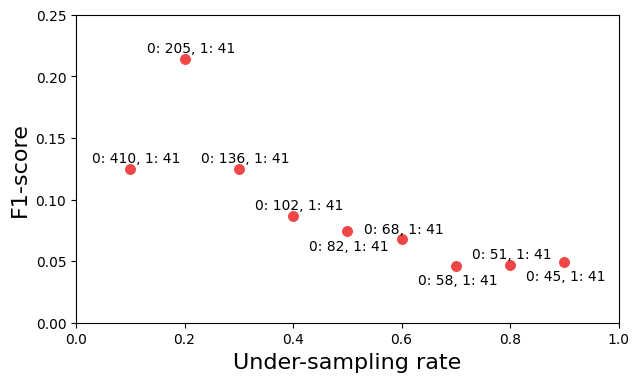

In [70]:
rates = ['0: 410, 1: 41', '0: 205, 1: 41', '0: 136, 1: 41', '0: 102, 1: 41',
         '0: 82, 1: 41', '0: 68, 1: 41', '0: 58, 1: 41', '0: 51, 1: 41', '0: 45, 1: 41']
us = np.arange(0.1, 1.0, 0.1)

fig, ax = plt.subplots(1, 1, figsize=(7,4))
ax.scatter(us, under_samp_matrix, marker = 'o', s=50, color=[.937, .275, .282],linewidth=0.8)

ax.set_ylabel('F1-score', color="black", fontsize=16)   
ax.set_xlabel('Under-sampling rate', color="black", fontsize=16)
ax.set_ylim([0, 0.25])
ax.set_xlim([0,1])

for i, txt in enumerate(rates):
    j=0.005
    if i == 8 or i== 6 or i==4:
        j = -0.015
    ax.annotate(txt, (us[i]-0.07, under_samp_matrix[i]+j))
    
plt.savefig('under-sampling.jpg',bbox_inches='tight', dpi=150)
plt.show()

Example of combining random oversampling and undersampling for imbalanced data

In [7]:
"""
print(f'Initial class count in TRAIN: {Counter(y_train)}')
# define oversampling strategy 1\10, 409/
over_sampler = SMOTEN(sampling_strategy = 0.1, n_jobs= -1, random_state=0)
# fit and apply the transform
x_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
# summarize class distribution
print(f'Class count in TRAIN after over-sampling: {Counter(y_train_over)}') """

"\nprint(f'Initial class count in TRAIN: {Counter(y_train)}')\n# define oversampling strategy 1\x08, 409/\nover_sampler = SMOTEN(sampling_strategy = 0.1, n_jobs= -1, random_state=0)\n# fit and apply the transform\nx_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)\n# summarize class distribution\nprint(f'Class count in TRAIN after over-sampling: {Counter(y_train_over)}') "

In [8]:
"""# define undersampling strategy
under_sampler = RandomUnderSampler(sampling_strategy = 0.9 ,random_state=42)
# fit and apply the transform
x_train_under, y_train_under = under_sampler.fit_resample(x_train_over, y_train_over)
# summarize class distribution
print(f'Class count in TRAIN after under-sampling: {Counter(y_train_under)}')"""

"# define undersampling strategy\nunder_sampler = RandomUnderSampler(sampling_strategy = 0.9 ,random_state=42)\n# fit and apply the transform\nx_train_under, y_train_under = under_sampler.fit_resample(x_train_over, y_train_over)\n# summarize class distribution\nprint(f'Class count in TRAIN after under-sampling: {Counter(y_train_under)}')"